In [99]:
#from biozorromodel import BioZorro
from datasets import load_from_disk
from encoders import BioZorroCollator

In [121]:
#lm_datasets = load_from_disk('data/filtered_protein_mrna_genes')
lm_datasets = load_from_disk('/efs-private/single_cell_data/out_veloc_data_unfiltered') #Just filtered Velocity
#lm_datasets = load_from_disk('/shared/fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all')

In [ ]:
lm_datasets = lm_datasets.rename_column('total_index','expression_index')
lm_datasets = lm_datasets.rename_column('total_data','expression_data')

In [ ]:
import numpy as np
from tqdm import tqdm
from collections import defaultdict
mins = defaultdict(list)
maxs = defaultdict(list)
length = defaultdict(list)
for sample in tqdm(lm_datasets):
    for k,v in sample.items():
        if "data" in k or "index" in k:
            try:
                mins[k].append(np.min(v))
                maxs[k].append(np.max(v))
                length[k].append(len(v))
            except:
                print(k)

In [43]:
import numpy as np
from tqdm import tqdm
from collections import defaultdict
data_points = defaultdict(list)
for sample in tqdm(lm_datasets):
    for d, idx in zip(sample['velocity_data'],sample['velocity_index']):
        data_points[idx].append(d)

100%|█████████████████| 396548/396548 [08:12<00:00, 805.50it/s]


In [ ]:
data_var= np.zeros(2000)
for idx, d in data_points.items():
    data_var[idx] = np.var(d)

Text(0, 0.5, 'Counts of Genes With Variance')

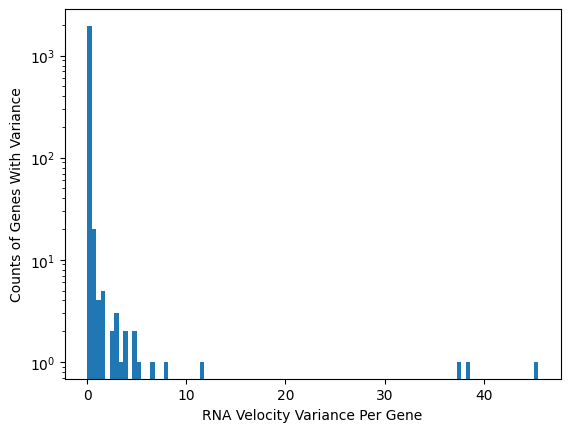

In [75]:
plt.hist(data_var, bins=100)
plt.yscale('log')
hv = np.nonzero(data_var > 1)[0]
plt.xlabel("RNA Velocity Variance Per Gene")
plt.ylabel("Counts of Genes With Variance")

In [ ]:
for idx in hv:
    #print(len(data_points[idx]))
    plt.hist(data_points[idx], bins=100, alpha=0.3)
plt.legend(hv)
plt.yscale('log')
print(hv)

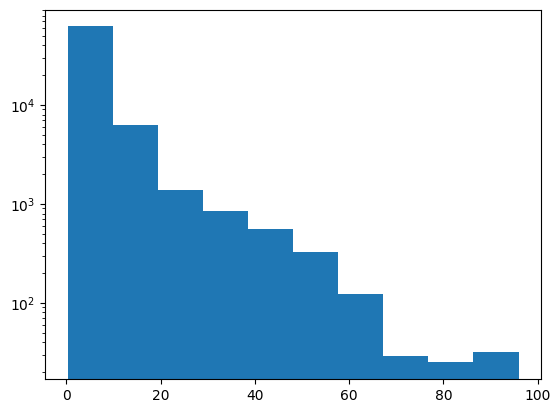

In [41]:
import matplotlib.pyplot as plt
plt.hist(maxs['velocity_data'])
plt.yscale('log')

In [ ]:
[print(f"{x},") for x in hv]

In [16]:
#keep =  ['spliced_index', 'unspliced_index', 'spliced_data', 'unspliced_data']
keep = ['expression_index','expression_data','spliced_index', 'unspliced_index', 'spliced_data', 'unspliced_data']
remove = list()
for key in lm_datasets.features.keys():
    if key not in keep:
        remove.append(key)
lm_datasets = lm_datasets.remove_columns(remove)

In [17]:
from torch.utils.data import DataLoader
default_data_collator = BioZorroCollator(pad_len=2048, pad_token=0)
dataloader = DataLoader(lm_datasets.with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)

In [18]:
dl = iter(dataloader)
batch = next(dl)

In [57]:
#https://ai.stackexchange.com/questions/28564/how-to-determine-the-embedding-size
import numpy as np
vocab_size = 18817
num_embeddings = int(75.6496 * np.log(vocab_size + 176.623) - 41.4457)
print(num_embeddings)

703


In [74]:
2.5*10**5*256/8

8000000.0

In [62]:
config = {
    "dim": num_embeddings, #hidden size
    "depth": 3, #layers
    "spliced_input_dim": num_embeddings, #embedding_size
    "unspliced_input_dim": num_embeddings,
    "dim_head":64, #don't know, head hidden size?
    "heads": 4, #num heads
    "ff_mult": 4, #Feed forward multiplier
    "num_fusion_tokens": 16,
    "vocab_size": vocab_size
}

model = BioZorro(**config)

In [ ]:
for n,p in model.named_parameters():
    if p.requires_grad:
        print(f"{n}:{p.numel()/10**6}")

In [ ]:
outputs = model(**batch)

In [41]:
outputs

BioZorroPretrainingLossOutput(losses=BioZorroPretrainingLossesCollection(contrastive_loss=tensor(10.3229, grad_fn=<DivBackward0>), fusion_loss_spliced=tensor(2.3723, grad_fn=<DivBackward0>), fusion_loss_unspliced=tensor(3.2532, grad_fn=<DivBackward0>)), spliced_output=None, unspliced_output=None, fusion_output=None)

In [ ]:
outputs.loss.backward()

In [ ]:
import wandb
wandb.init()

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm

epochs=100
optimizer = AdamW(model.parameters(), lr=0.0001)
num_training_steps = epochs * len(dataloader)
progress_bar = tqdm(range(num_training_steps))

#print("Start training: {}".format(strftime("%Y-%m-%d %H:%M:%S", gmtime())))
## Start model training and defining the training loop
model.train()
for epoch in range(epochs):
    for batch in dataloader:
        #batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        optimizer.zero_grad()
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
        wandb.log({"loss":loss.detach().to("cpu")})
    print(f"Epoch {epoch}: loss: {loss.detach()}")
        #
    #if xm.is_master_ordinal(local=False):
    wandb.log({"epoch_loss":loss.detach().to("cpu")})

logger.info("End training: {}".format(strftime("%Y-%m-%d %H:%M:%S", gmtime())))

In [17]:
from collections import defaultdict
import torch
losses = defaultdict(lambda: torch.Tensor([0.0]).to("cpu"))
losses['test']+=torch.Tensor([1.0])

# Scaling law results

In [5]:
import pandas as pd
import numpy as np
nparam = np.array([76.65,38.81,32.5, 26.23,
                   19.94,13.64,10.50,7.35])*10**6
nlayers = np.array([24,16,10,8,6,4,3,2])
sm_loss = { 'fusion_spliced': [0.05217,0.055660,0.05406000, 0.04967,
                               0.0688, 0.0625,0.06375,0.07791],
           'fusion_unspliced':[0.05201,0.055482,0.05395645, 0.04972,
                               0.06859,0.0624,0.06347,0.07738],
           'contrastive_loss':[0.051933,0.05556,0.054283, 0.0499,
                               0.06961,0.0638,0.06341,0.07857]
}
dm_loss = { 'fusion_spliced':[0.002226,0.004596, 0.0047380,0.003942,
                              0.005551,0.005522,0.005401,0.01271],
           'fusion_unspliced':[0.002172,0.0046209,0.0047747,0.004004,
                               0.005403,0.005479,0.005485,0.01249],
           'contrastive_loss':[0.002259,0.004727,0.0048772,0.00414,
                               0.005551,0.005278,0.005551,0.01522]
}

dm_loss=np.array(list(dm_loss.values()))
dm_loss = dm_loss.sum(axis=0)
#dm_loss=dm_loss[:,:-1].sum(axis=0)
sm_loss=np.array(list(sm_loss.values()))
sm_loss = sm_loss.sum(axis=0)
#sm_loss=sm_loss[:,:-1].sum(axis=0)
#nparam=nparam[:-1]
df = pd.DataFrame.from_dict({'dual':dm_loss,
                             'single':sm_loss,
                             'param':nparam})
df_m = pd.DataFrame.from_dict({'dual':dm_loss/dm_loss.mean(),
                               'single':sm_loss/sm_loss.mean(),
                               'param':nparam})
df.to_csv('prelim_scale_data.csv')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f33337f34d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  
/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f33317b8550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  
/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f33317b8c10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  
/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f33317379d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
/shared/miniconda3/lib/pyth

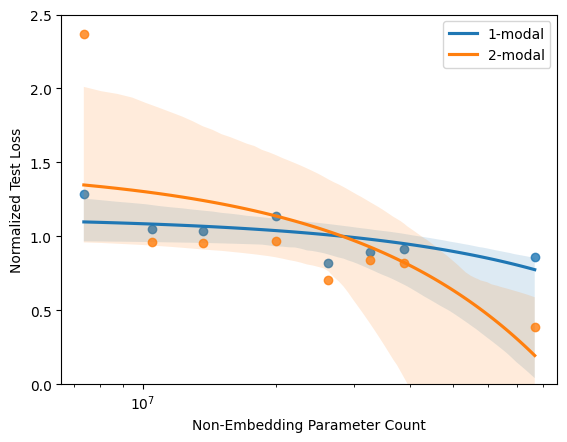

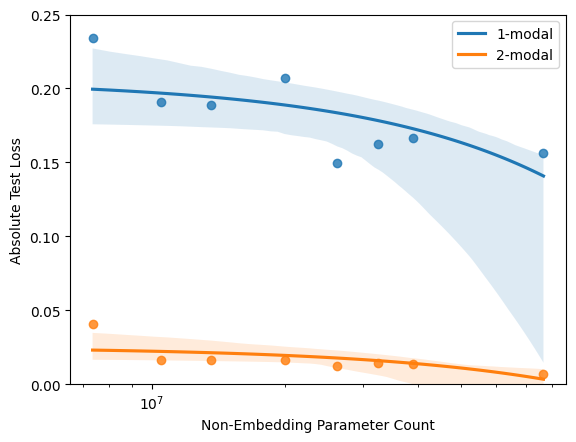

In [4]:
sm_loss_ = sm_loss
dm_loss_ = dm_loss
nparam_ = nparam
nlayers_ = nlayers
plt.clf()
plt.figure(1)
#plt.plot(nparam_,np.array(sm_loss_)/sm_loss_.mean(),'o-',
#         nparam_,np.array(dm_loss_)/dm_loss_.mean(),'x-')
sns.regplot(df_m, x='param',y='single')
sns.regplot(df_m, x='param',y='dual')
plt.xscale('log')
#plt.xlim([9*10**6,10**8])
plt.ylim([0,2.5])
plt.xlabel('Non-Embedding Parameter Count')
plt.ylabel('Normalized Test Loss')
plt.legend(['_nolegend_',"1-modal",'_nolegend_','_nolegend_',"2-modal"]) 
plt.figure(2)
#plt.plot(nparam_,np.array(sm_loss_),'o-',
#         nparam_,np.array(dm_loss_),'x-')
sns.regplot(df, x='param',y='single')
sns.regplot(df, x='param',y='dual')
plt.xscale('log')
plt.ylim([0,0.25])

#plt.xlim([5*10**6,10**8])
plt.xlabel('Non-Embedding Parameter Count')
plt.ylabel('Absolute Test Loss')
plt.legend(['_nolegend_',"1-modal",'_nolegend_','_nolegend_',"2-modal"]) 
#, "1-modal", "2-modal"])

# Other TEsts

In [1]:
# Get some indices in the top rankings
#indices = [x[0:5] for x in dataset3[0:10000]['velocity_index']]
#indices = [x for y in indices for x in y]

In [236]:
unique, counts = np.unique(indices, return_counts=True)
arrinds = counts.argsort()
unique = unique[arrinds]
counts = counts[arrinds]

In [ ]:
print(counts[-5:])
print(unique[-5:]) #indices to use
target_ids = unique[-5:]

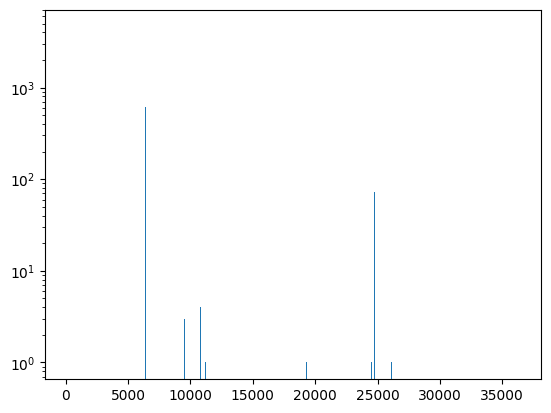

In [230]:
import matplotlib.pyplot as plt
plt.bar(unique,counts)
plt.yscale('log')
#plt.hist(indices, bins=36601)

In [265]:
vel_index = torch.tensor(dataset3[0]['velocity_index']) 
vel_val = torch.tensor(dataset3[0]['velocity_data']) 

idx = vel_index == 9999999 #target_ids[0]
x=vel_val[idx]
y = x.item() if x.nelement() != 0 else 0.0
y

0.0

# Testing Pretrained Model

In [203]:
from safetensors.torch import load_model
import json
import os
import torch

In [2]:
import datasets
!ls /shared/

/shared/miniconda3/envs/stp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ad98d3cd-26fb-4ee3-99c9-8a2ab085e737_combined_all
cc95ff89-2e68-4a08-a234-480eca21ce79_combined_all
fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all
fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all_veloc_sparse
fde199d2-a841-4ed1-aa65-b9e0af8969b1_combined_all
genecorpus_30M_10p_2048.dataset
genecorpus_30M_1p_2048.dataset
genecorpus_30M_2048.dataset
lost+found
miniconda3
neuron_cache
tmp


In [63]:
from multizorromodel import BioZorro, BioZorroWithLeaveOneOut
from encoders import BioZorroCollator
from velocitymodel import VelocityModel
import datasets
from torch.utils.data import DataLoader
from encoders import BioZorroCollatorWithTargets
#!ls training_output_17_52_26_10_2023
#output_dir = "training_output_22_45_26_10_2023" #Velocity fine tuned
output_dir = "training_output_01_30_07_11_2023"

In [64]:
!cat $output_dir/config.yaml

batch_size: 2
dataset: /shared/fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all #/shared/dataset3M
dim_head: 8
ds_frac: 1.0
ds_seed: 42
epochs: 4
ff_mult: 4
heads: 8
hidden_size: 512
layers: 5
lr: 0.0001
lr_scheduler_type: cosine
model: 3
num_fusion_tokens: 64
num_warmup_steps: 3000
split: 0.1
run_eval_loop: false 


In [128]:
from datasets import load_from_disk
#dataset = datasets.load_from_disk(config['dataset'])
#dataset2 = datasets.load_from_disk('/shared/fde199d2-a841-4ed1-aa65-b9e0af8969b1_combined_all')
#dataset3 = load_from_disk('/shared/fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all') #_all_veloc_sparse')
dataset3 = load_from_disk('/efs-private/single_cell_data/out_veloc_data_unfiltered')
for col in dataset3.features:
    if 'counts' in col:
        col = col.split('_')[0]
        dataset3 = dataset3.rename_column(f'{col}_counts',f'{col}_data')
#lm_datasets = lm_datasets.rename_column('total_data','expression_data')

In [129]:
import yaml
import os
with open(os.path.join(output_dir,'config.yaml'), 'r') as file:
    config = yaml.safe_load(file)
print(config)

{'batch_size': 8, 'dataset': '/efs-private/single_cell_data/out_veloc_data_unfiltered', 'decoder_hidden_size': 1024, 'decoder_num_layers': 0, 'ds_frac': 1, 'ds_seed': 42, 'epochs': 4, 'final_hidden_state': False, 'find_unused_parameters': False, 'fit_indices': [209, 265, 286, 347, 369, 503, 749, 1037, 1047, 1410, 1519, 1524, 1751, 1752, 1753, 1754, 1756, 1758, 1760, 1767, 1779, 1781, 1783, 1784, 1791], 'gene_indices': [], 'layers_to_unfreeze': ['return_tokensattn_pool.norm.gamma', 'attn_pool.to_q.weight', 'attn_pool.to_kv.weight', 'attn_pool.to_out.weight'], 'load_checkpoint': False, 'lr': 0.0001, 'lr_scheduler_type': 'cosine', 'model': 3, 'model_dir': 'training_output_01_30_07_11_2023', 'norm': [0.2, 0.0], 'num_warmup_steps': 3000, 'output_dir': 'training_output_23_54_07_11_2023', 'output_type': ['fusion'], 'pad_length': 1024, 'vocab_size': 36602}


In [70]:
#with open(os.path.join(output_dir,'model_config.json'),'r') as f:
#    model_config = json.load(f)
#print(model_config)
model_config = {'dim': 512, 'depth': 5, 'dim_head': 8, 'heads': 8, 'ff_mult': 4, 'num_fusion_tokens': 64, 'vocab_size': 36602}

In [130]:
#keep =  ['spliced_index', 'unspliced_index', 'spliced_data', 'unspliced_data']
#keep = ['expression_index','expression_counts','spliced_index', 'unspliced_index', 'spliced_counts', 'unspliced_counts']
keep = ['velocity_index','velocity_data','expression_index',
        'expression_data','spliced_index', 'unspliced_index',
        'spliced_data', 'unspliced_data']

remove = list()
for key in dataset3.features.keys():
    if key not in keep:
        remove.append(key)
#dataset = dataset.remove_columns(remove)
#dataset2 = dataset2.remove_columns(remove)
dataset3 = dataset3.remove_columns(remove)
dataset3 = dataset3.train_test_split(0.1, seed=42)
dataset3

DatasetDict({
    train: Dataset({
        features: ['spliced_index', 'spliced_data', 'unspliced_index', 'unspliced_data', 'expression_index', 'expression_data', 'velocity_index', 'velocity_data'],
        num_rows: 356893
    })
    test: Dataset({
        features: ['spliced_index', 'spliced_data', 'unspliced_index', 'unspliced_data', 'expression_index', 'expression_data', 'velocity_index', 'velocity_data'],
        num_rows: 39655
    })
})

In [134]:
default_data_collator = BioZorroCollator(pad_len=1024, pad_token=0)
#default_data_collator = BioZorroCollatorWithTargets(pad_len=1024, pad_token=0, 
#                                                    target_ids=[ 5717, 33042, 21509, 27559, 33027],
#                                                    norm=[0.2,0.5])

#dataloader2 = DataLoader(dataset.with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)
#dataloader3 = DataLoader(dataset3['test'].with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)


In [135]:
target_ids = [209,265,286,347,369,503,749,1037,1047,
                        1410,1519,1524,1751,1752,1753,1754,1756,
                        1758,1760,1767,1779,1781,1783,1784,1791,]

In [137]:
default_data_collator = BioZorroCollatorWithTargets(pad_len=1024, pad_token=0, 
                                                    target_ids=target_ids,
                                                    norm=[0.2,0.0])

#dataloader2 = DataLoader(dataset.with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)
dataloader3 = DataLoader(dataset3['train'].with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)


In [138]:
#dl=iter(dataloader)
#dl=iter(dataloader2)
dl = iter(dataloader3)
batch = next(dl)
#batch2= next(dl2):q

for k,v in batch.items():
    print(f"{k} {v.shape}")
    
print(len(dataloader3))

spliced_index torch.Size([4, 1024])
spliced_data torch.Size([4, 1024])
unspliced_index torch.Size([4, 1024])
unspliced_data torch.Size([4, 1024])
expression_index torch.Size([4, 1024])
expression_data torch.Size([4, 1024])
velocity torch.Size([4, 25])
9914


In [93]:
model = BioZorroWithLeaveOneOut(**model_config)
model.eval()
with torch.no_grad():
    output1 = model(**{k:v for k,v in batch.items() if 'velocity' not in k})
print(model)

BioZorroWithLeaveOneOut(
  (loss): BioZorroPretrainingLossFLOOM(
    (contrastive_loss_spliced_unspliced): ContrastiveLossWithTemperature()
    (contrastive_loss_spliced_expression): ContrastiveLossWithTemperature()
    (contrastive_loss_unspliced_expression): ContrastiveLossWithTemperature()
    (fusion_loss_spliced): ContrastiveLossWithTemperature()
    (fusion_loss_unspliced): ContrastiveLossWithTemperature()
    (fusion_loss_expression): ContrastiveLossWithTemperature()
    (fusion_loss_invariance): MSELoss()
  )
  (attn_pool): Attention(
    (norm): LayerNorm()
    (to_q): Linear(in_features=512, out_features=64, bias=False)
    (to_kv): Linear(in_features=512, out_features=128, bias=False)
    (to_out): Linear(in_features=64, out_features=512, bias=False)
  )
  (spliced_embedding): BioZorroEncoder(
    (gene_encoder): GeneEncoder(
      (embedding): Embedding(36602, 512, padding_idx=0, max_norm=1.0)
    )
    (counts_encoder): ContinuousValueEncoder(
      (dropout): Dropout(p=0.

In [116]:
velocitymodel=VelocityModel(backbone_model=model, 
                            decoder_num_layers=0,
                            decoder_hidden_size = 1024,
                            layers_to_unfreeze=[],
                            backbone_hidden_size = 512, 
                            output_size = 25,
                            output_types = ['fusion'])
output_dir = "training_output_23_54_07_11_2023"
!ls $output_dir

self.decoder = Sequential(
  (0): Linear(in_features=512, out_features=25, bias=True)
)
config.yaml	   random_states_0.pkl	random_states_5.pkl
model.safetensors  random_states_1.pkl	random_states_6.pkl
model_config.json  random_states_2.pkl	random_states_7.pkl
optimizer.bin	   random_states_3.pkl	scheduler.bin
pytorch_model.bin  random_states_4.pkl


In [204]:
import torch
load_model(velocitymodel,os.path.join(output_dir,'model.safetensors'))
#checkpoint_path = os.path.join(output_dir, '3')
#checkpoint_path = output_dir
#checkpoint = torch.load(os.path.join(checkpoint_path, 'pytorch_model.bin'), map_location="cpu")
#print(checkpoint)
#velocitymodel.load_state_dict(checkpoint)
#model.load_state_dict(checkpoint)

(set(), [])

In [118]:
def zero_modes(batch, modes_to_zero):
    for mode in modes_to_zero:
        batch[mode]=batch[mode]*0
    return batch

In [205]:
from tqdm import tqdm
output=[]
output_zero=[]
output_1zero=[]
veloc=[]
pcc = {0:list(),1:list(),2:list()}
infer_model = velocitymodel.eval()
#infer_model = model.eval()
with torch.no_grad():
    for i in tqdm(range(100)):
        #batch = next(dl)
        #batch2 = next(dl2)
        batch = next(dl)
        #print(batch)
        #batch = {k:v for k,v in batch.items() if 'velocity' not in k}
        #output.append(model(**batch))
        #output2.append(model(**batch2))
        # NOTE: the ** needs to be removed for velocity
        out = infer_model(batch,
                         return_logit=True)
        out_1zeroed = infer_model(zero_modes(batch,[#'spliced_index',
                                 #'spliced_data',
                                 'unspliced_index',
                                 'unspliced_data']), 
                                 return_logit=True)
        out_zeroed = infer_model(zero_modes(batch,['spliced_index',
                                                 'spliced_data',
                                                 'unspliced_index',
                                                 'unspliced_data']), 
                                                  return_logit=True,
                                                    )
        veloc.append(batch['velocity'])
        pcc[2].append(out_zeroed[1]['pcc'])
        pcc[0].append(out[1]['pcc'])
        pcc[1].append(out_1zeroed[1]['pcc'])

        output.append(out[2])
        output_zero.append(out_zeroed[2])
        output_1zero.append(out_1zeroed[2])
#print(output)

100%|████████████████████████████████████████████████████████████████████████| 100/100 [20:23<00:00, 12.23s/it]


In [190]:
veloc

[tensor([[ 0.0000e+00,  0.0000e+00, -4.2787e-02,  1.7812e-02,  1.6966e-02,
           0.0000e+00,  0.0000e+00,  3.3899e+00,  0.0000e+00,  1.3553e-02,
           1.6068e-01,  8.8373e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0571e-02, -9.8486e-02,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  3.1291e+00,  0.0000e+00,  2.1143e-02,
           1.1305e-01,  8.3698e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.1983e-04,  4.4163e-03,  8.2486e-01,  1.3822e-01,  0.0000e+00,
           0.0000e+00,  4.4031e-03,  0.0000e+00, -1.7624e-08,  0.0000e+00,
           0.0000e+00,  5.4855e-03,  0.0000e+00, -2.8469e-03,  0.0000e+00,
           2.4126e-03, 

In [191]:
def refactor(outputs):
    #print(outputs)
    #assert isinstance(outputs,list)
    out_dict = {k:[] for k in outputs[0] if 'loss' not in k}
    for batch in outputs:
        for key in out_dict.keys():
            out_dict[key].append(batch[key])
    out_dict = {k:torch.cat(v) for k,v in out_dict.items()}
    return out_dict

0.6100164


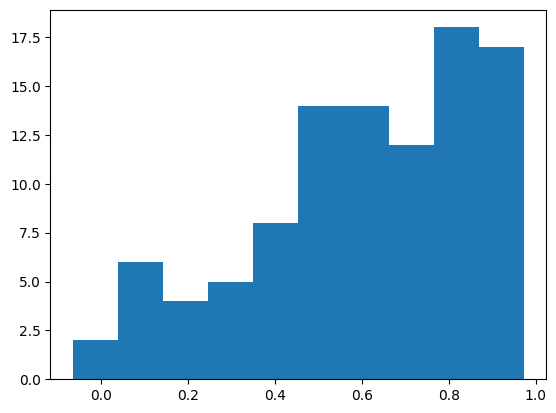

In [209]:
plt.hist(pcc[0])
print(np.mean(pcc[0]))

In [193]:
output_1zero = refactor(output_1zero)

RuntimeError: Tensor.__contains__ only supports Tensor or scalar, but you passed in a <class 'str'>.

In [172]:
output = refactor(output)
output_zero = refactor(output_zero)
print(output)

RuntimeError: Tensor.__contains__ only supports Tensor or scalar, but you passed in a <class 'str'>.

In [220]:
veloc_val_cat.shape

torch.Size([400, 25])

In [212]:
def refactor_velocity(outputs):
    print(outputs[1].shape)
    print(len(outputs))
    d=[x for x in outputs]
    print(d[0].shape)
    return torch.cat(d)
output_val_cat = refactor_velocity(output)
veloc_val_cat = torch.cat(veloc)

torch.Size([4, 25])
100
torch.Size([4, 25])


In [213]:
print(output_val_cat.shape)
veloc_val_cat.shape

torch.Size([400, 25])


torch.Size([400, 25])

Text(0.5, 1.0, 'RNA Velocity from 3 Pretraining + 1 fine Tuning Epoch\n with 1 unfrozen Pooling layer')

<Figure size 640x480 with 0 Axes>

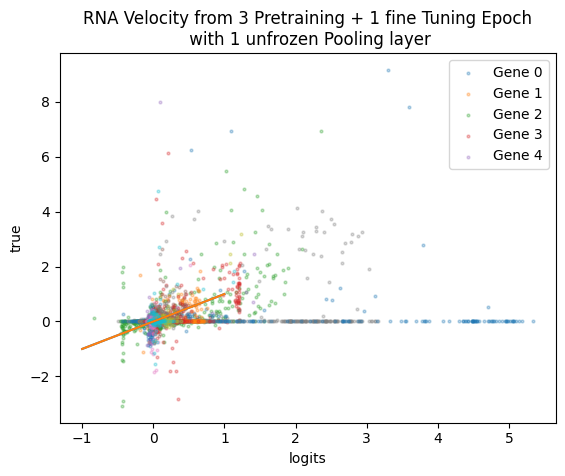

In [221]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(0)
for i in range(20):
    #plt.figure(i)
    plt.scatter(output_val_cat[:,i],veloc_val_cat[:,i],alpha=0.3, s=4)
    plt.xlabel('logits')
    plt.ylabel('true')
    #plt.ylim(-1,1)
    #plt.xlim(-1,1)
plt.plot(range(-1,2),range(-1,2))
plt.plot(range(-1,2),range(-1,2))
plt.legend(['Gene ' + str(i) for i in range(5)])
plt.title('RNA Velocity from 3 Pretraining + 1 fine Tuning Epoch\n with 1 unfrozen Pooling layer')
    #plt.figure(1)
    #plt.hist(veloc_cat.flatten())

In [ ]:
import matplotlib.pyplot as plt
plt.figure(0)
for i in range(5):
    #plt.figure(i)
    plt.scatter(output_cat[:,i]-0.5,veloc_cat[:,i]-0.5,alpha=0.3, s=4)
    plt.xlabel('logits')
    plt.ylabel('true')
    plt.ylim(-0.5,0.5)
    plt.xlim(-0.5,0.5)
plt.plot(range(-1,2),range(-1,2))
plt.plot(range(-1,2),range(-1,2))
plt.legend(['Gene ' + str(i) for i in range(5)])
plt.title('RNA Velocity from 3 Pretraining + 1 fine Tuning Epoch\n with 1 unfrozen Pooling layer')
    #plt.figure(1)
    #plt.hist(veloc_cat.flatten())

In [ ]:
#print(output['spliced'][0][:10])
print(output2['spliced'][0][:10])

In [90]:
import numpy as np
import matplotlib.pyplot as plt
def plot_cosines(output, output2=None, log=False, vmin=None, vmax=None, plot_diag=True):
    if not output2:
        output2 = output
    cos = torch.nn.CosineSimilarity(dim=0)
    mat_dict={}
    for k,v in output.items():
        l = v.shape[0]
        mat_dict[k]=np.zeros([l,l])
        v2 = output2[k]
        for i in range(l):
            for j in range(l):
                #print(f"{i},{j},{cos(output.fusion[i],output.fusion[j])}")
                if log:
                    mat_dict[k][i,j]=np.log10(cos(v[i],v2[j]))
                else:
                    mat_dict[k][i,j]=cos(v[i],v2[j])

    for k,mat in mat_dict.items():
        plt.figure()
        plt.title(k)
        plt.imshow(mat, vmin=vmin, vmax=vmax)
        plt.colorbar()
        if plot_diag:
            plt.figure()
            plt.title(f"{k} diagonals")
            bins = np.linspace(0,1.0,100)
            plt.hist(np.diagonal(mat), bins=bins, alpha=0.3,density=True)
            plt.hist(mat.flatten(), bins=bins, alpha=0.3, density=True)
            plt.ylim(0,50)
            plt.xlim(0.75,1.0)
            plt.legend(["diag","all"])
    #if plot_diag:
        """
        plt.figure()
        plt.title("diagonals")
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        plt.hist(diags.values(), bins=20)
        plt.legend(diags.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('Diag Cosine Similarity')
        plt.figure()
        plt.title("diagonals")
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        diags_norm = {k:np.diagonal(mat)-np.mean(mat_dict[k]) for k, mat in mat_dict.items()}
        plt.hist(diags_norm.values(), bins=20)
        plt.legend(diags_norm.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('%Cosine Similarity Change from Mean of Diagonal')
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        diags_norm = {k:np.diagonal(mat)-np.mean(mat_dict[k]) for k, mat in mat_dict.items()}
        plt.hist(diags_norm.values(), bins=20)
        plt.legend(diags_norm.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('%Cosine Similarity Change from Mean of Diagonal')        
        """
        #plt.figure()
        #plt.title("")

        

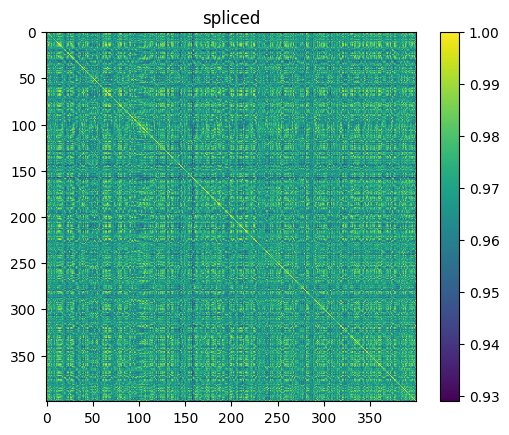

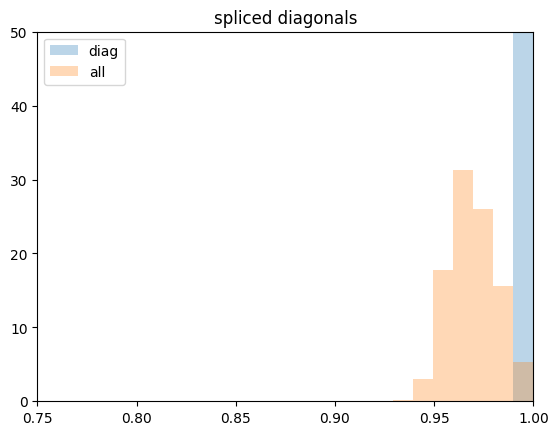

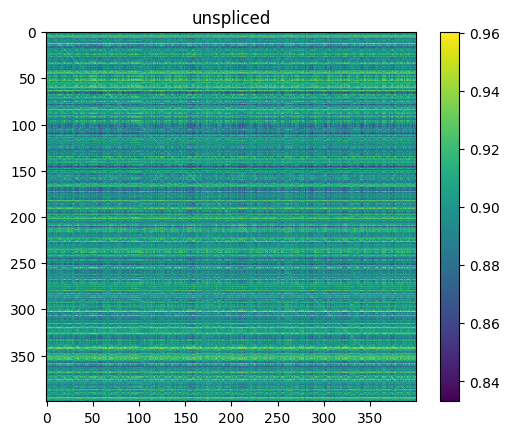

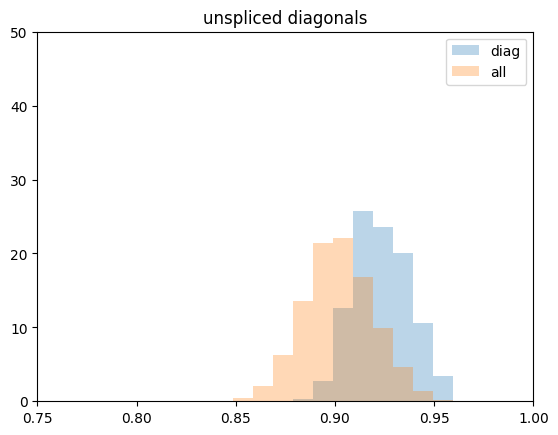

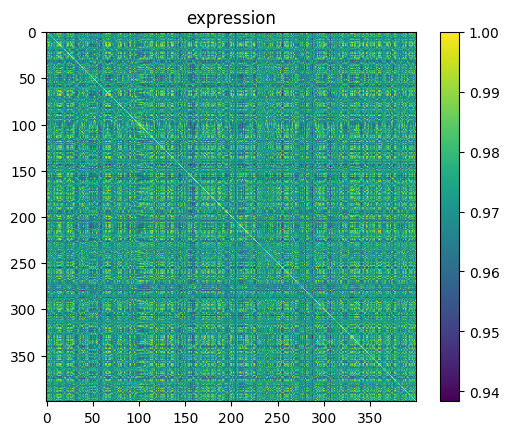

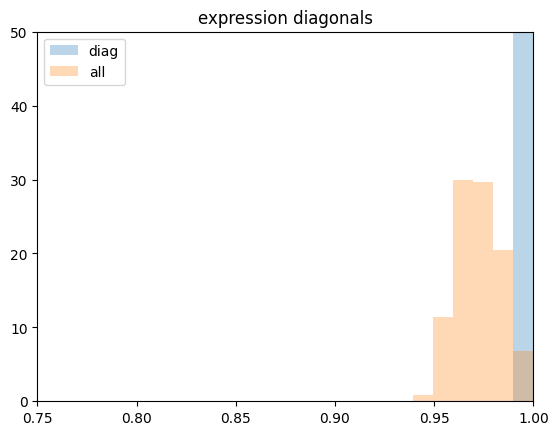

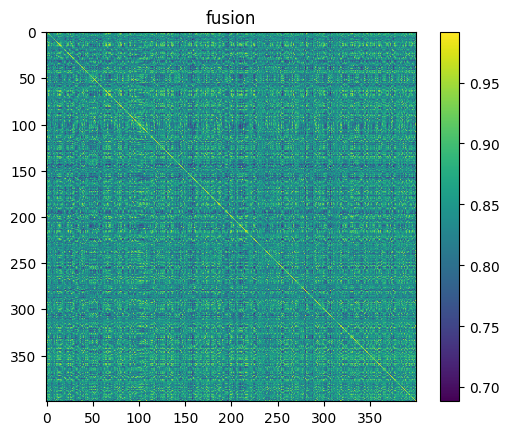

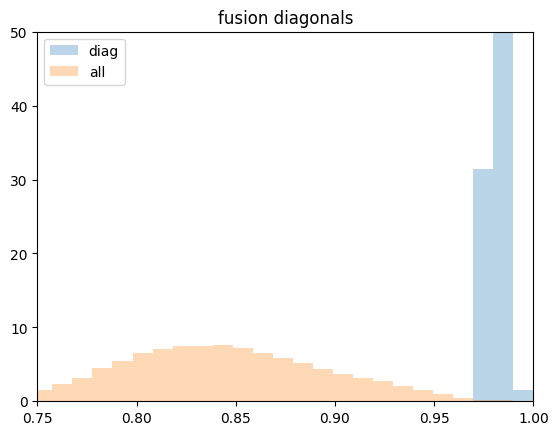

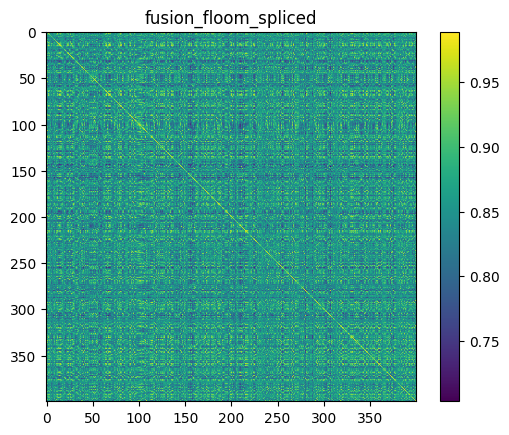

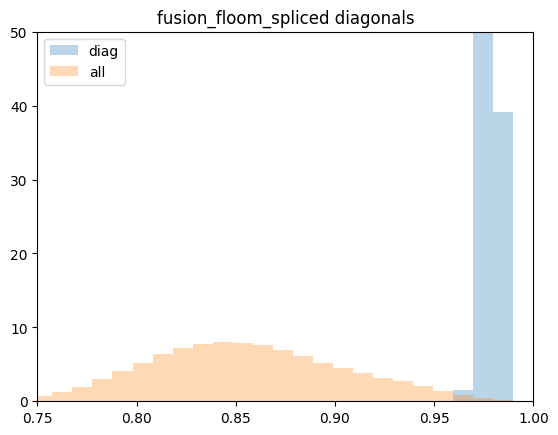

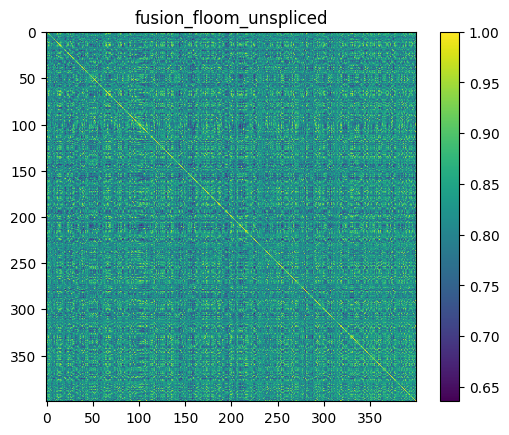

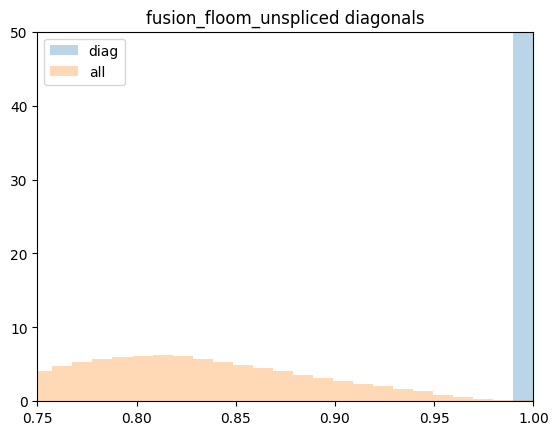

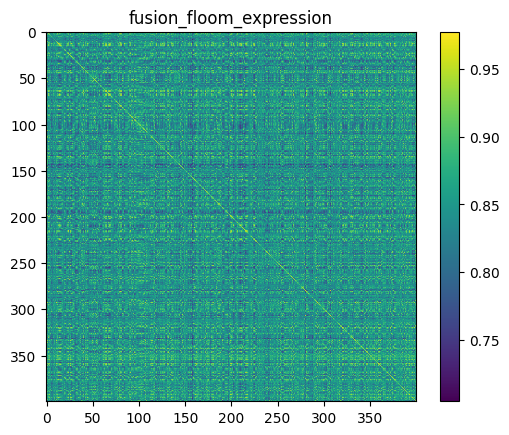

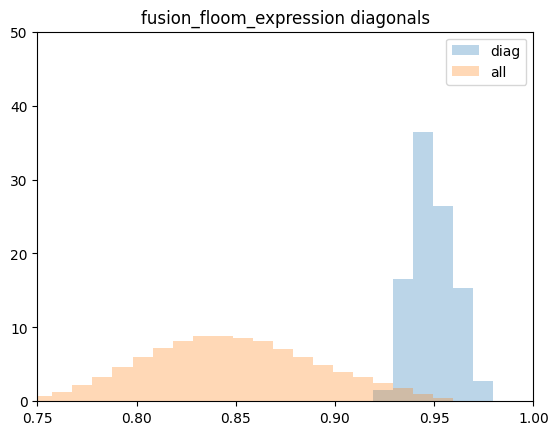

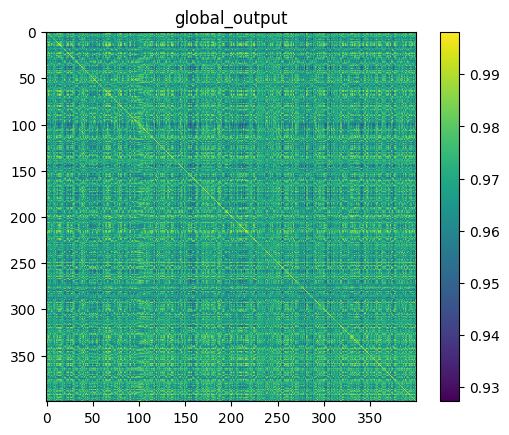

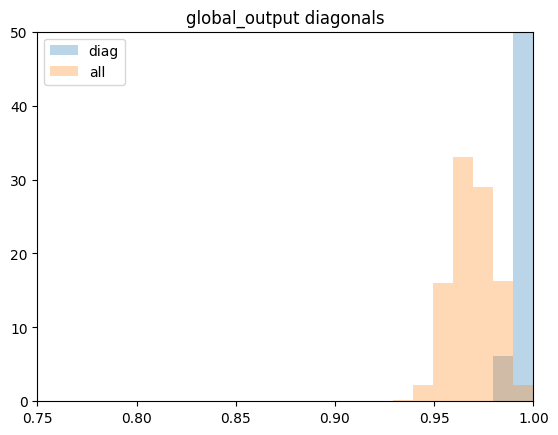

In [91]:
plot_cosines(output,  output_1zero)#,vmin=0.75)

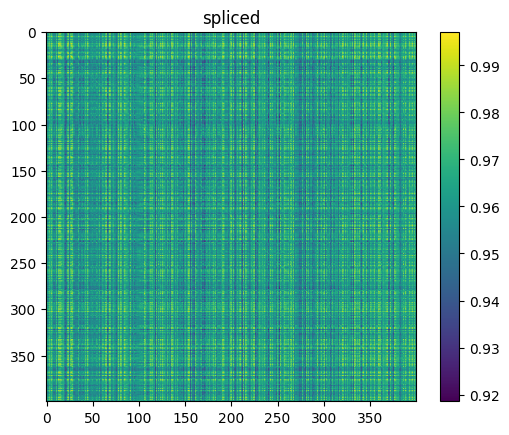

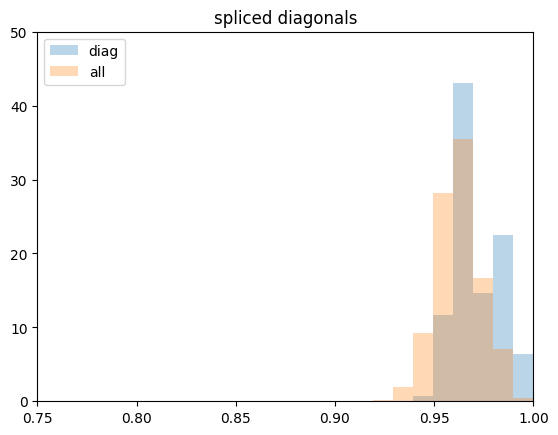

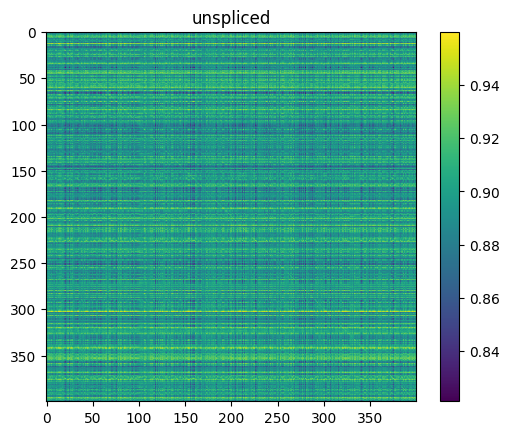

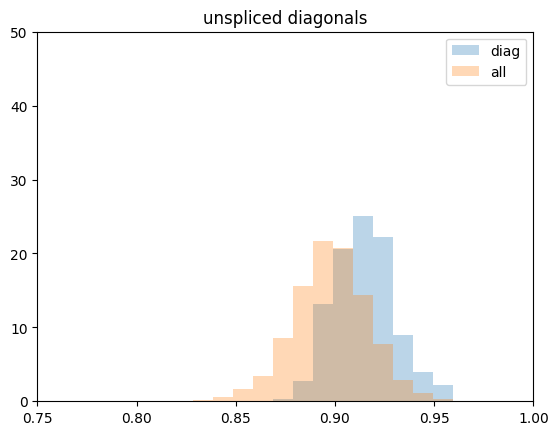

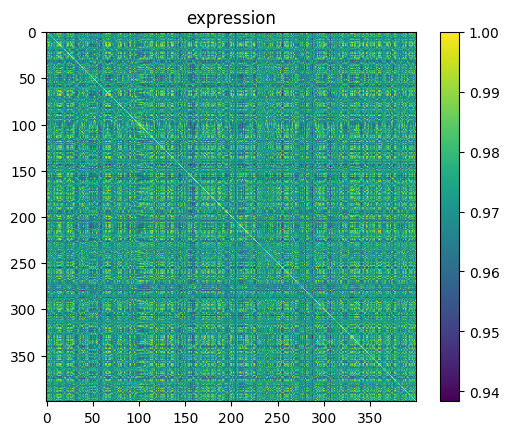

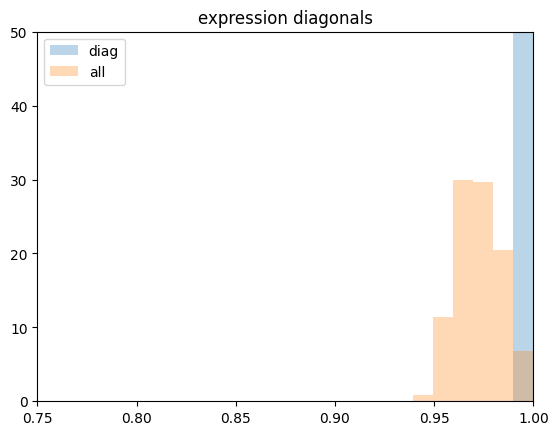

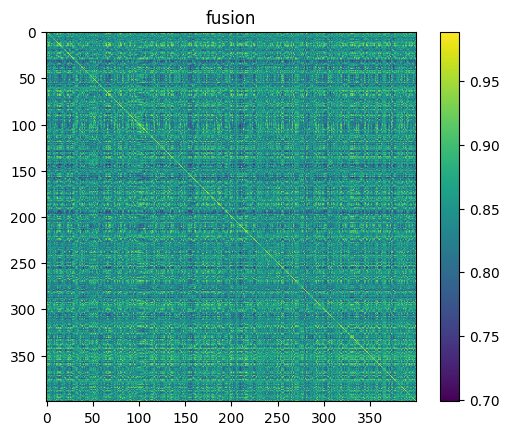

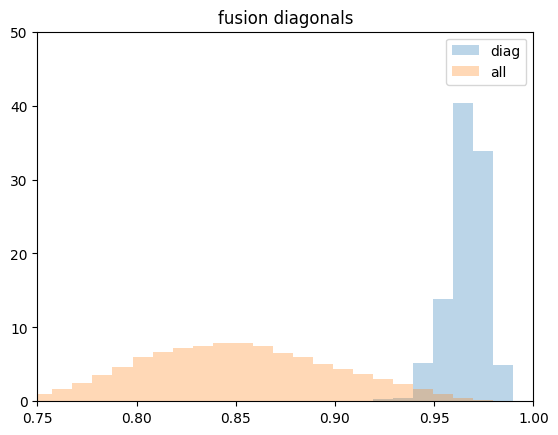

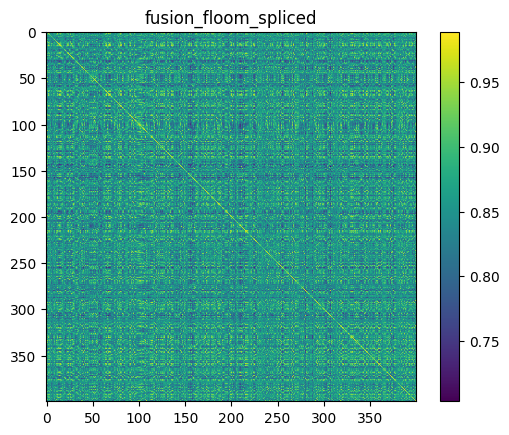

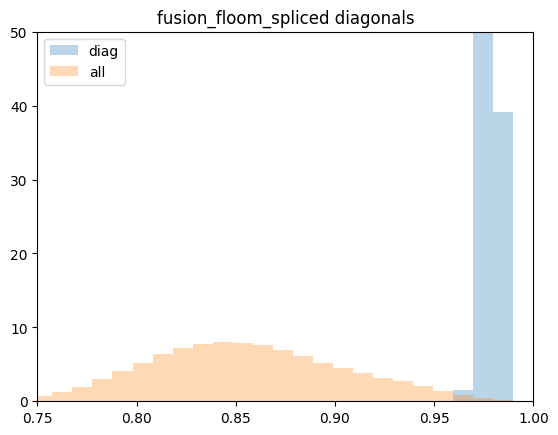

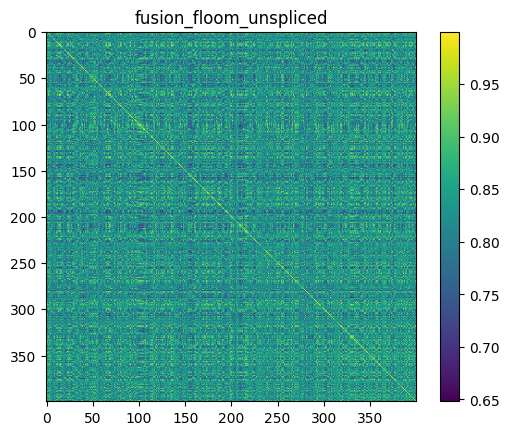

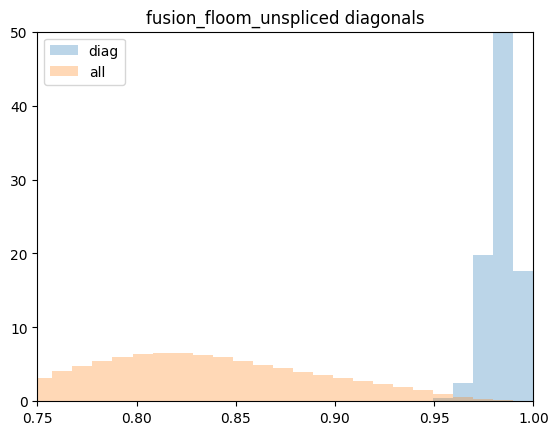

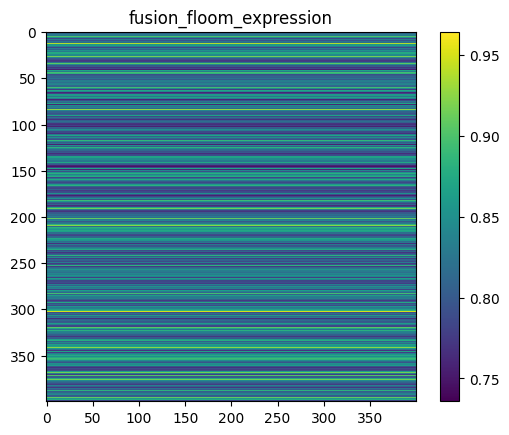

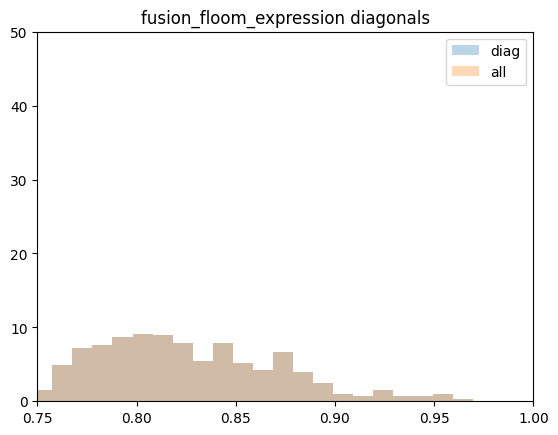

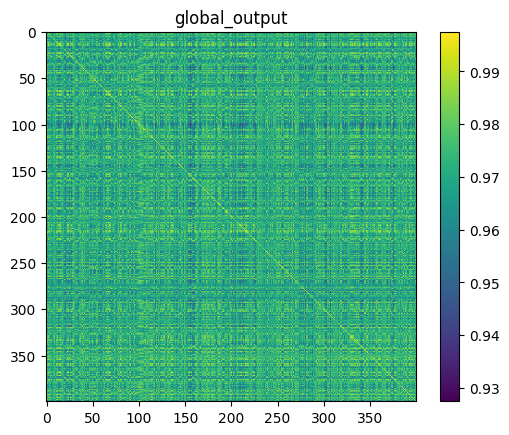

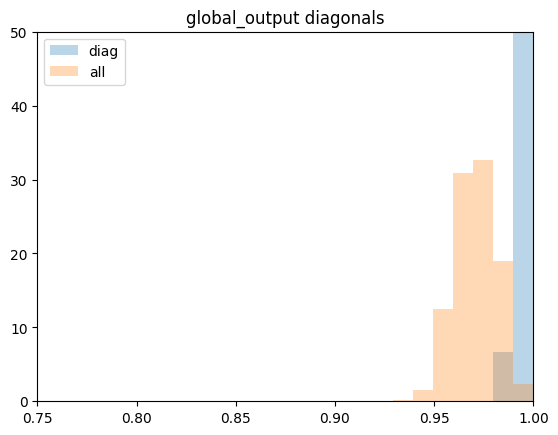

In [92]:
plot_cosines(output, output_zero) #, vmin=0.99)

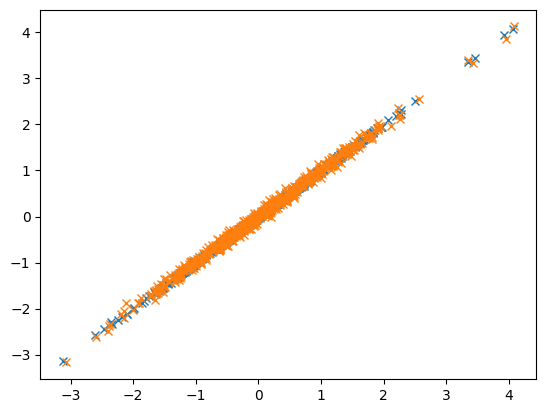

In [118]:
import matplotlib.pyplot as plt
plt.plot(output.spliced[0].T, output2.spliced[0].T,'x')
plt.plot(output.spliced[1].T, output2.spliced[3].T,'x')

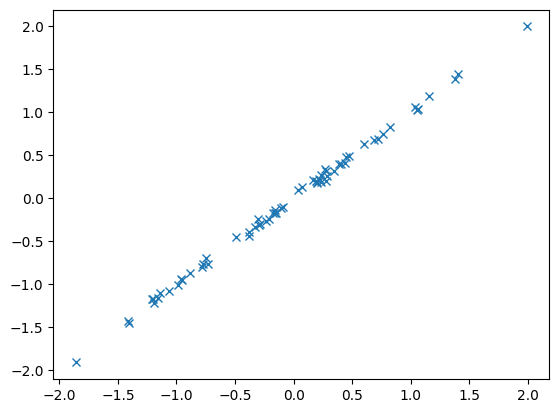

In [35]:
plt.plot(output.expression[0].T, output2.expression[0].T,'x')

In [97]:
output

BioZorroPretrainingLossOutput(losses=BioZorroPretrainingLossesCollection(contrastive_loss_spliced_unspliced=tensor(0.4164), contrastive_loss_spliced_expression=tensor(0.4097), contrastive_loss_unspliced_expression=tensor(0.4155), fusion_loss_spliced=tensor(0.4160), fusion_loss_unspliced=tensor(0.4218), fusion_loss_expression=tensor(0.4208)), spliced=tensor([[-1.1495, -1.1352, -0.2678,  ..., -1.6399,  1.2685, -1.6200],
        [-1.1184, -1.1473, -0.2358,  ..., -1.6374,  1.3286, -1.6621],
        [-1.1103, -1.1614, -0.2176,  ..., -1.6670,  1.3458, -1.6997],
        [-1.1442, -1.1956, -0.2705,  ..., -1.7048,  1.3194, -1.6719]]), unspliced=tensor([[-0.5714, -0.6153, -0.6491,  ...,  0.5839,  1.0429, -1.6685],
        [-0.5403, -0.6274, -0.6171,  ...,  0.5865,  1.1030, -1.7106],
        [-0.5323, -0.6415, -0.5989,  ...,  0.5568,  1.1202, -1.7482],
        [-0.5661, -0.6758, -0.6517,  ...,  0.5191,  1.0937, -1.7204]]), expression=tensor([[-1.1063, -0.1184, -0.6933,  ...,  0.0146,  0.0636,  0.

# Attention masking tests

In [116]:
import torch
token_types = torch.tensor(list((
    *((0,) * 1024),
    *((1,) * 1024),
    *((2,) * 1024),
    *((3,) * 1024),
)), dtype=torch.long)

In [117]:
token_types.shape

torch.Size([4096])

In [118]:
from einops import rearrange, repeat

In [119]:
token_types_attend_from = rearrange(token_types, 'i -> i 1')
token_types_attend_to = rearrange(token_types, 'j -> 1 j')

In [120]:
zorro_mask = token_types_attend_from == token_types_attend_to

In [121]:
zorro_mask = zorro_mask | (token_types_attend_from == 3)

0
-1024:-769
1
-768:-513
2
-512:-257
3
-256:-1


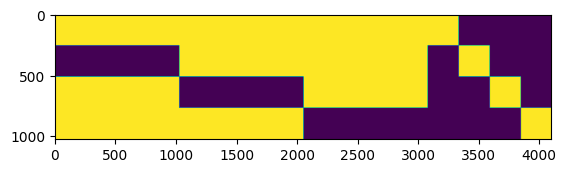

In [189]:
token_types
floom_mask = [token_types != i for i in range(-1,3)]
for idx, tokens in enumerate(floom_mask):
    print(idx)
    a = -256*4 + 256*idx
    b = -256*4 + 256*(idx+1)-1
    print(f"{a}:{b}")
    tokens[-256*4:] = False
    tokens[a:b]= True
floom_mask = repeat(floom_mask, 'i j -> (i i2) j', i2=256)
plt.imshow(floom_mask)#, aspect = 1000)

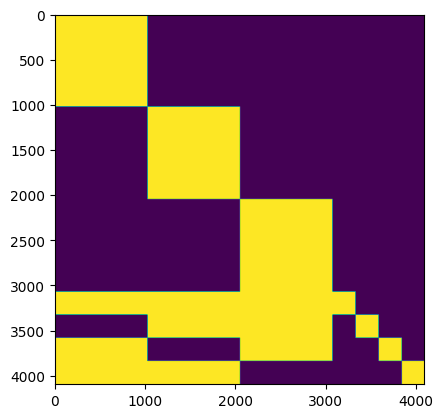

In [190]:
import matplotlib.pyplot as plt
zorro_mask[token_types == 3] = floom_mask
plt.imshow(zorro_mask)

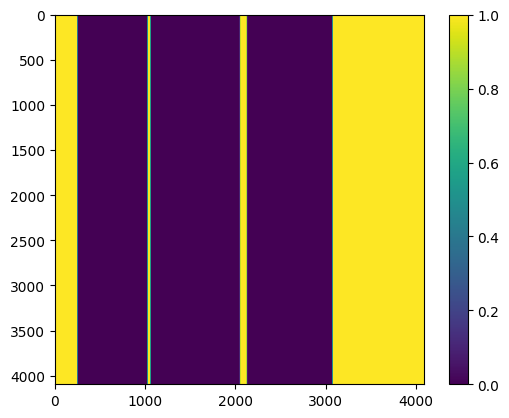

In [125]:
from einops import pack,repeat
padding, ps = pack((
    batch['expression_index'] != 0,
    batch['spliced_index'] != 0,
    batch['unspliced_index'] != 0,
    torch.ones(4,1024),
   #Also need fusion tokens here torch.tensor((True,) * 16),
    ), 'b *')
attn_mask = repeat(padding, 'b j -> b i j', i=token_types.shape[-1])
plt.imshow(attn_mask[0].squeeze())
plt.colorbar()

In [126]:
attn_mask.unsqueeze(1).shape

torch.Size([4, 1, 4096, 4096])

/tmp/ipykernel_914643/776592073.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


[Text(0, -500.0, '0'),
 Text(0, 0.0, 'Modality 1'),
 Text(0, 500.0, 'Modality 2'),
 Text(0, 1000.0, 'Modality 3'),
 Text(0, 1500.0, 'Fusion -1'),
 Text(0, 2000.0, 'Fusion 0'),
 Text(0, 2500.0, 'Fusion 1'),
 Text(0, 3000.0, 'Fusion 2'),
 Text(0, 3500.0, 'Global Tokens'),
 Text(0, 4000.0, ''),
 Text(0, 4500.0, '')]

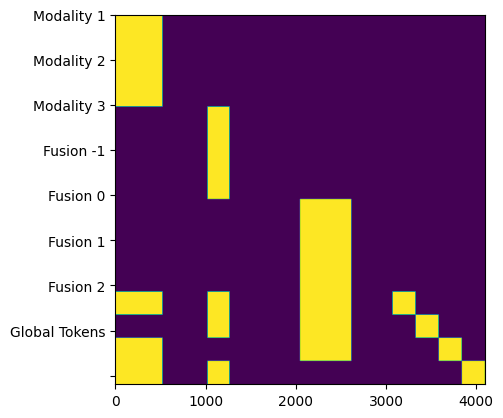

In [191]:
ax = plt.subplot(1,1,1)
im = ax.imshow(attn_mask[3,:,:] * zorro_mask)
labels = ['0','Modality 1','Modality 2','Modality 3','Fusion -1', 'Fusion 0', 'Fusion 1', 'Fusion 2','Global Tokens']
ax.set_yticklabels(labels)

In [72]:
torch.empty(0)

tensor([])

In [73]:
batch

{'expression_index': tensor([[  7,  10,  60,  ...,   0,   0,   0],
         [ 18,  49,  53,  ...,   0,   0,   0],
         [  3,  17,  26,  ...,   0,   0,   0],
         [ 60,  67, 136,  ...,   0,   0,   0]]),
 'spliced_index': tensor([[ 10,  60, 204,  ...,   0,   0,   0],
         [ 49, 134, 351,  ...,   0,   0,   0],
         [ 17,  46,  60,  ...,   0,   0,   0],
         [ 60, 183, 191,  ...,   0,   0,   0]]),
 'unspliced_index': tensor([[  7, 103, 238,  ...,   0,   0,   0],
         [ 18,  53, 120,  ...,   0,   0,   0],
         [ 26, 153, 198,  ...,   0,   0,   0],
         [136, 160, 332,  ...,   0,   0,   0]]),
 'expression_data': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 'spliced_data': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 2., 1.,  ..., 0., 0., 0.]]),
 'unspl

In [193]:
return_token_types = (0,1,2,3,3,3,3,4)
return_token_types_tensor = torch.tensor(list(return_token_types))
max_return_tokens = len(return_token_types)
dim=512
return_tokens = torch.nn.Parameter(torch.randn(max_return_tokens, dim))
return_tokens = repeat(return_tokens, 'n d -> b n d', b=4)

In [194]:
return_tokens.shape

torch.Size([4, 8, 512])

In [195]:
pool_mask = rearrange(return_token_types_tensor, 'i -> i 1') == token_types_attend_to
pool_mask = pool_mask | (rearrange(return_token_types_tensor, 'i -> i 1') == torch.ones_like(
            token_types_attend_to, dtype=torch.long) * 4)

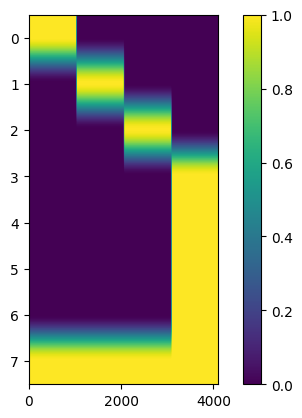

In [196]:
plt.imshow(pool_mask.to(torch.long), aspect=1000) #'auto')
plt.colorbar()

torch.Size([4096])
torch.Size([8, 4096])


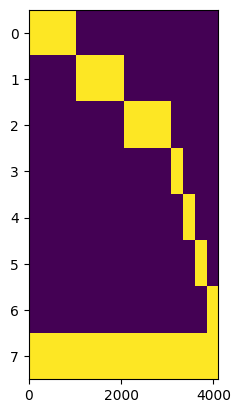

In [197]:
floom_pool_mask = torch.block_diag(torch.ones((1,256)), 
                              torch.ones((1,256)), 
                              torch.ones((1,256)), 
                              torch.ones((1,256)))
print(token_types.shape)
select_mask = (return_token_types_tensor == 3).unsqueeze(1) *(token_types == 3).unsqueeze(0)
print(select_mask.shape)
pool_mask[select_mask] = floom_pool_mask.to(torch.bool).flatten()
#floom_mask = repeat(floom_mask, 'i j -> i j')
ax = plt.subplot(1,1,1)
im = ax.imshow(pool_mask, aspect=1000, interpolation='none')

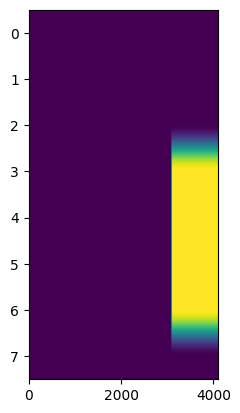

In [170]:
plt.imshow((return_token_types_tensor == 3).unsqueeze(1) *
           (token_types == 3).unsqueeze(0), aspect =1000)

ValueError: only one element tensors can be converted to Python scalars

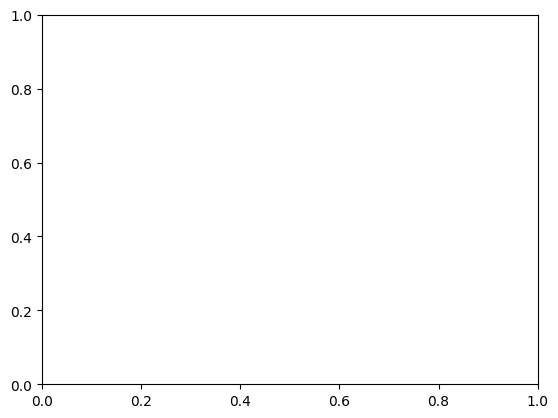

In [179]:
plt.plot(pool_mask.T)

torch.Size([4, 8, 4096])


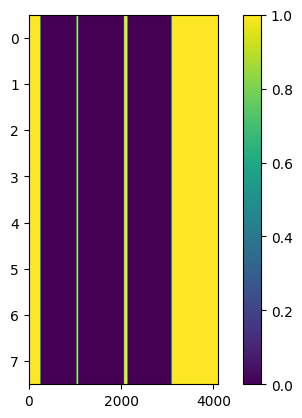

In [180]:
padding_mask = repeat(padding, 'b j -> b i j', i=pool_mask.shape[0])
print(padding_mask.shape)
plt.imshow(padding_mask[0,:,:].squeeze(), aspect=1000)
plt.colorbar()

/tmp/ipykernel_914643/1809391518.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


[Text(0, -1.0, '0'),
 Text(0, 0.0, 'Modality 1'),
 Text(0, 1.0, 'Modality 2'),
 Text(0, 2.0, 'Modality 3'),
 Text(0, 3.0, 'Fusion -1'),
 Text(0, 4.0, 'Fusion 0'),
 Text(0, 5.0, 'Fusion 1'),
 Text(0, 6.0, 'Fusion 2'),
 Text(0, 7.0, 'Global Tokens'),
 Text(0, 8.0, '')]

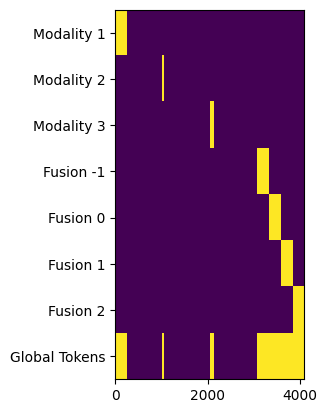

In [198]:
pool_mask = pool_mask * padding_mask
ax = plt.subplot(1,1,1)
im = ax.imshow(pool_mask[0], aspect=1000, interpolation='none')
#labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['0','Modality 1','Modality 2','Modality 3','Fusion -1', 'Fusion 0', 'Fusion 1', 'Fusion 2','Global Tokens']
ax.set_yticklabels(labels)

In [160]:
q=torch.tensor([[1,2],
                [1,1]])
k=torch.tensor([[1,1],
                [2,1]])
v=q

In [163]:
from torch import einsum
sim = einsum('i d, d j -> i j', q, k) #Standard mm multipy
sim = einsum('i d, j d -> i j', q, k) #mm multiply with k transpose
print(sim)
#sim = sim.masked_fill(~attn_mask, -torch.finfo(sim.dtype).max)
#attn = sim.softmax(dim=-1)
attn = sim
out = einsum('i j, j d -> i d', attn, v) #standard multiply with no tranpose
print(out)
### SO COLUMNS SHOULD BE -inf for the mask!

tensor([[3, 4],
        [2, 3]])
tensor([[ 7, 10],
        [ 5,  7]])


In [156]:
sim

tensor([[2, 0],
        [0, 2]])

# Combine datasets

In [85]:
from datasets import concatenate_datasets, load_from_disk
import os
os.environ['HF_DATASETS_CACHE']='/shared/.cache/hugginface/dataset'
datasets = [
   'ad98d3cd-26fb-4ee3-99c9-8a2ab085e737_combined_all',
    'fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all',
    'cc95ff89-2e68-4a08-a234-480eca21ce79_combined_all',
    'fde199d2-a841-4ed1-aa65-b9e0af8969b1_combined_all'
]
root = '/shared/'
loaded_datasets=[]
for dataset in datasets:
    loaded_datasets.append(load_from_disk(os.path.join(root,dataset)))
all_datasets=concatenate_datasets(loaded_datasets)

In [88]:
shuffled_dataset = all_datasets.shuffle(seed=42)

In [89]:
len(shuffled_dataset)

2630923

In [91]:
shuffled_dataset.save_to_disk(os.path.join(root,'dataset3M'))

In [29]:
import torch

In [37]:
t = torch.zeros(10)

In [38]:
t[torch.tensor([0,4,9])]=torch.tensor([1,2,3], dtype=torch.float)

In [39]:
t

tensor([1., 0., 0., 0., 2., 0., 0., 0., 0., 3.])